# PCA for Image Denoising

In [4]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds,eigs
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
def plot_mnist(X,T=None,name='img.png'):
  fig,ax=plt.subplots(10,10,figsize=(10,10))
  ax=ax.flatten()
  if(T!=None):
    fig.suptitle(T,fontsize=25)
  for img,a in zip(X,ax):
    a.imshow(img.reshape(16,16),cmap='gray');
    a.axis('off');
  plt.savefig(name,bbox_inches='tight', pad_inches=0)
  plt.close()

# a) Data Loading and Visualization

In [6]:
Data=pd.read_csv('/content/drive/MyDrive/ID5055 assignments/PCA assignment 1/noisy_mnist.csv',header=None)

In [7]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9298 entries, 0 to 9297
Columns: 256 entries, 0 to 255
dtypes: float64(256)
memory usage: 18.2 MB


In [9]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.264608,0.060024,0.146811,0.336136,0.280311,-0.139760,0.233830,0.371765,0.669086,0.530387,...,0.911594,1.065910,0.813509,0.559103,0.576087,0.143439,0.082710,-0.040196,0.104130,0.104220
1,-0.108767,-0.202736,-0.170056,0.332693,0.186255,0.280204,0.253478,0.363563,0.039638,0.300219,...,0.564037,0.439045,0.601399,0.758090,0.615006,0.495628,0.418448,0.651263,0.450334,0.362928
2,-0.199832,-0.295294,-0.099008,0.026376,0.074813,0.157204,0.042648,0.261847,-0.017913,0.042030,...,0.006110,-0.227748,0.048597,0.511590,0.850562,0.497355,0.232944,-0.157354,-0.015151,0.002892
3,0.277441,-0.031975,-0.070889,0.047647,0.075778,0.556461,0.741170,0.604523,0.770517,0.562931,...,0.290294,0.645014,0.688283,-0.053283,0.047673,0.014939,0.152352,0.105156,-0.062622,-0.164624
4,0.256846,-0.118795,-0.155106,-0.134832,0.297439,0.241704,0.469472,0.815539,0.763322,0.545774,...,0.475727,1.085077,1.194813,0.838231,0.959414,0.852181,0.439244,0.093923,-0.093429,0.102673


# Data Preprocessing

In [10]:
def train_test_split(data,test_split=0.2,shuffle=False):
  D=np.array(data)
  if shuffle == True:
    pass
  l=D.shape[0]
  split=int((1-test_split)*l)
  test=D[split:,:]
  train=D[:split,:]
  return train,test

# b) Splitting the Data in 80-20

In [11]:
Train,Test=train_test_split(Data)

# a) Visualization of Train Images

(-0.5, 773.5, 868.5, -0.5)

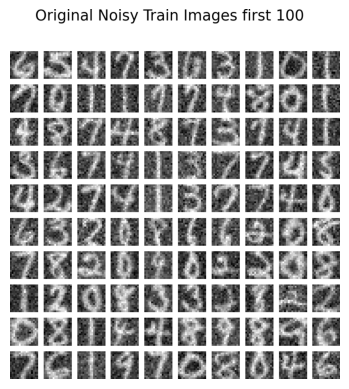

In [12]:
plot_mnist(Train[:100],T='Original Noisy Train Images first 100')#Visualization of first 100 images
img=Image.open('/content/img.png')
plt.imshow(np.array(img))
plt.axis('off')

# Denoiser Class

In [13]:
class Denoiser:

  def __init__(self,data,final_dim) :
    self.data=data
    self.mean=data.mean(axis=0)
    self.std=data.std(axis=0)
    self.dim=final_dim

  #SVD Based
  def get_svs(self) :
    zero_mean=(self.data-self.mean)/self.std
    u,s,v=svds(zero_mean,k=self.dim)
    v=v.T
    return v

  #Covariance_matrix Based
  def get_eigvs(self):
    zero_mean=(self.data-self.mean)/self.std
    l=self.data.shape[0]
    cov=(1/l)*((zero_mean.T).dot(zero_mean))
    vals,eig=eigs(cov,k=self.dim)
    eig=np.real(eig)
    vals=np.real(vals)
    return eig

  def get_dim(self,D,svs=False,eigvs=False):
    Dt=(D-self.mean)/self.std
    if svs==True :
      v=self.get_svs()
      final=Dt.dot(v)
      return final,v
    if eigvs==True :
      v=self.get_eigvs()
      final=Dt.dot(v)
      return final,v

  def Reconstruct(self,D,svs=False,eigvs=False) :
    if svs==True:
      Final,v=self.get_dim(D,svs=svs)
    if eigvs==True:
      Final,v=self.get_dim(D,eigvs=eigvs)
    Recons=Final.dot(v.T)*self.std+self.mean
    return Recons

In [14]:
dim=[50,75,100,150,200,250]
Re_dim=[]
for i in dim:
  Re_dim.append(Denoiser(Train,final_dim=i))

# Randomly showing 100 test images

(-0.5, 773.5, 868.5, -0.5)

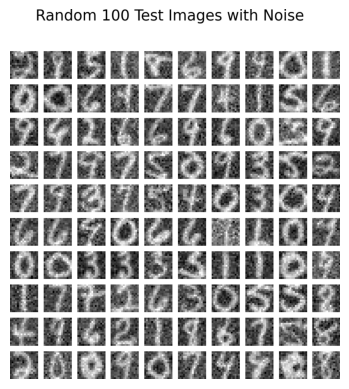

In [15]:
np.random.seed(0)
index=np.random.randint(0,len(Test),100)
plot_mnist(Test[index],"Random 100 Test Images with Noise")#Test Images with noise
img=Image.open('/content/img.png')
plt.imshow(np.array(img))
plt.axis('off')

# c) Performing PCA with SVD, with dimesnions [50,75,100,150,200,250]; Plotting them to compare

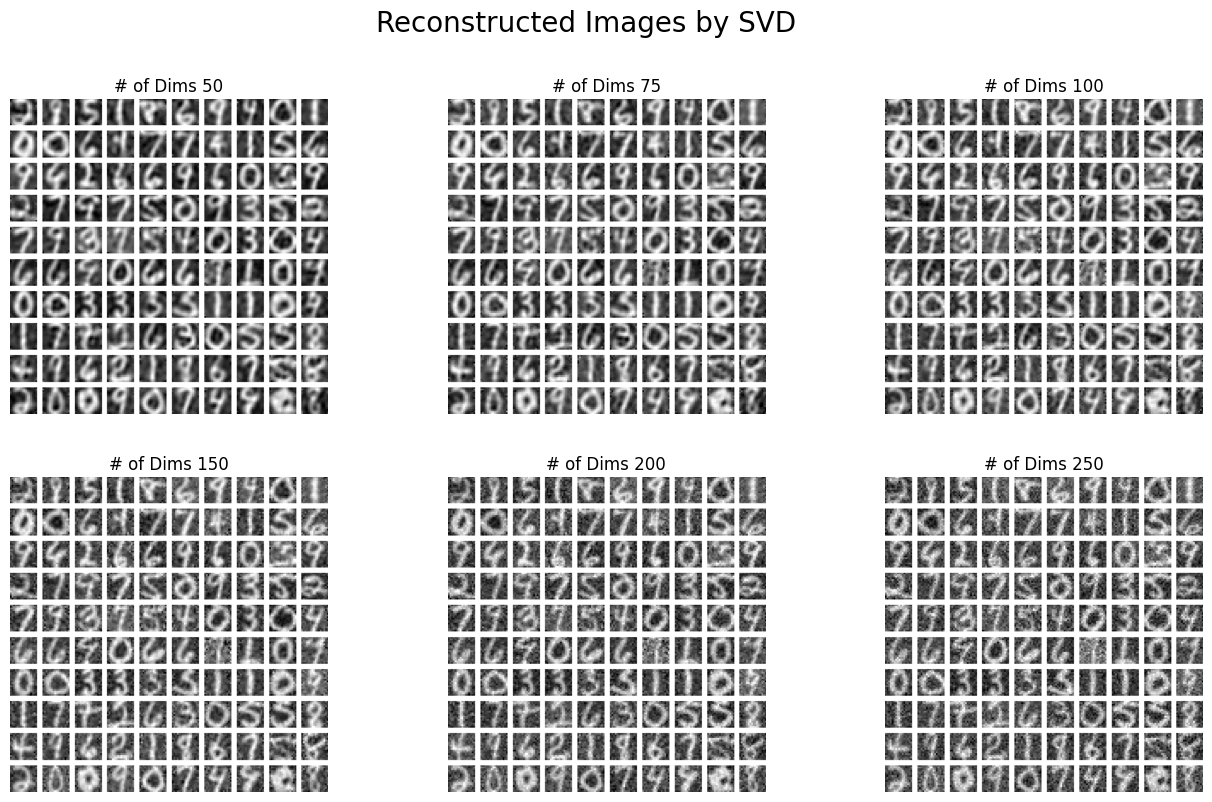

In [16]:
#Reconstructed by SVD
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
fig.suptitle('Reconstructed Images by SVD',fontsize=20)
axs=axs.ravel()
for i in range(len(dim)):
  Final_test_sv=Re_dim[i].Reconstruct(Test,svs=True)
  plot_mnist(Final_test_sv[index],T=None)
  img=Image.open('/content/img.png')
  img=np.array(img)
  axs[i].imshow(img)
  axs[i].axis('off')
  axs[i].set_title(f'# of Dims {dim[i]}')

# Extra : Reconstruction using the eigen vectors of Covariance Matrix (Not Part of Question)

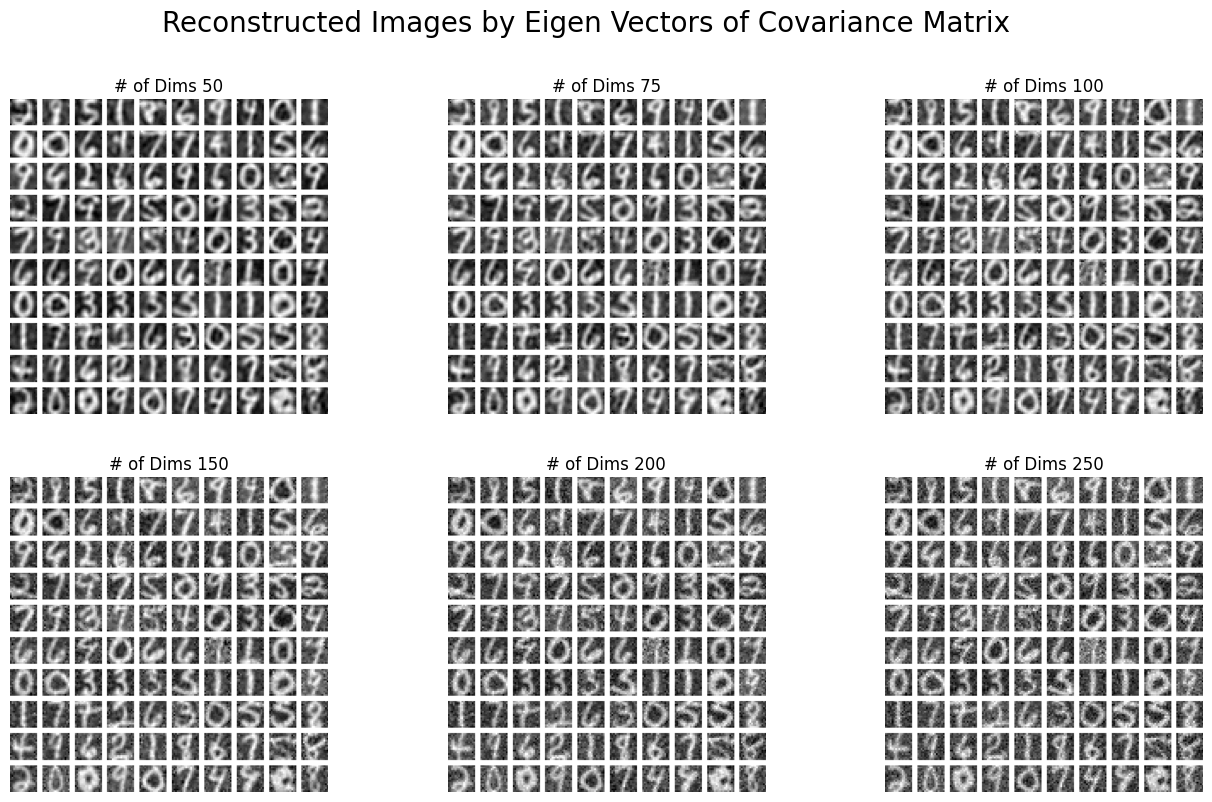

In [ ]:
#Reconstructed by Covariance
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
fig.suptitle('Reconstructed Images by Eigen Vectors of Covariance Matrix',fontsize=20)
axs=axs.ravel()
for i in range(len(dim)):
  Final_test_sv=Re_dim[i].Reconstruct(Test,eigvs=True)#change to Covariance Matrix
  plot_mnist(Final_test_sv[index],T=None)
  img=Image.open('/content/img.png')
  img=np.array(img)
  axs[i].imshow(img)
  axs[i].axis('off')
  axs[i].set_title(f'# of Dims {dim[i]}')

In [ ]:
# saving the images
for i in range(len(dim)):
  Final_test_sv=Re_dim[i].Reconstruct(Test,svs=True)
  plot_mnist(Final_test_sv[index],T=f'Number of Dims {dim[i]}',name=f'dim{dim[i]}.png')

# End of Question 1